# Head

In [11]:
import pandas as pd

In [2]:
cluster_df = pd.read_parquet("/home/zqlyu2/projects/periodical-clustering/data/2010s/clustering_results/cluster_df.parquet")

In [3]:
cluster_df['kmeans_label']

202381698     17
137773608     17
125754415     17
3880285        8
111155417     11
              ..
2764485818    18
83454320      13
16507453      13
121509672     21
53107364      11
Name: kmeans_label, Length: 20038, dtype: int32

In [4]:
ref_df = pd.read_parquet("/home/zqlyu2/projects/periodical-clustering/data/2010s/MAG_venue_ref.parquet")

In [5]:
vid_to_kmeans = dict(zip(cluster_df.index, cluster_df['kmeans_label']))

ref_df['citing_kmeans_label'] = ref_df.index.map(vid_to_kmeans)
ref_df['source_kmeans_label'] = ref_df['ReferenceVID'].map(vid_to_kmeans)
ref_df.dropna(subset=['citing_kmeans_label', 'source_kmeans_label'], inplace=True)

ref_df.drop(columns=['ReferenceVID'], inplace=True)
ref_df.reset_index(drop=True, inplace=True)
ref_df.set_index('citing_kmeans_label', inplace=True)

In [6]:
ref_df.index = ref_df.index.astype(int)
ref_df.source_kmeans_label = ref_df.source_kmeans_label.astype(int)


In [7]:
ref_df

,source_kmeans_label
citing_kmeans_label,
6,6
6,6
6,15
6,6
6,6
...,...
11,11
11,11
11,11


In [8]:
# Group by citing_kmeans_label and source_kmeans_label
citation_counts = ref_df.groupby(['citing_kmeans_label', 'source_kmeans_label']).size().reset_index(name='count')

# Calculate statistics for each citing cluster
node_stats = []
for cluster in citation_counts['citing_kmeans_label'].unique():
    cluster_data = citation_counts[citation_counts['citing_kmeans_label'] == cluster]
    
    # Get the same-cluster citations
    same_cluster_citations = cluster_data[cluster_data['source_kmeans_label'] == cluster]['count'].sum() \
        if cluster in cluster_data['source_kmeans_label'].values else 0
    
    # Get the different-cluster citations
    diff_cluster_citations = cluster_data[cluster_data['source_kmeans_label'] != cluster]['count'].sum()
    
    # Calculate total citations
    total_citations = same_cluster_citations + diff_cluster_citations
    
    # Calculate percentages
    pct_same = (same_cluster_citations / total_citations * 100) if total_citations > 0 else 0
    
    node_stats.append({
        'cluster': cluster,
        'inner_citations': same_cluster_citations,
        'outer_citations': diff_cluster_citations,
        'total_citations': total_citations,
        'inner_pct': pct_same
    })

# Create a dataframe with the results
node_stats_df = pd.DataFrame(node_stats).sort_values('cluster')
print(f"Citations by cluster statistics (total of {len(node_stats_df)} clusters)")
node_stats_df

Citations by cluster statistics (total of 26 clusters)


,cluster,inner_citations,outer_citations,total_citations,inner_pct
0,0,711800,548049,1259849,56.498834
1,1,2825306,4350637,7175943,39.371913
2,2,545215,1038813,1584028,34.419530
3,3,3032857,2105357,5138214,59.025510
4,4,8835127,7723805,16558932,53.355657
5,5,4895488,3669681,8565169,57.155767
6,6,12930483,7209477,20139960,64.203122
7,7,11827200,10544479,22371679,52.866841
8,8,5666184,4822988,10489172,54.019364
9,9,7727996,5622399,13350395,57.885898


In [47]:
node_stats_df.to_csv("/home/zqlyu2/projects/periodical-clustering/structure/node.csv", index=False)

In [9]:
citation_counts.drop(citation_counts[citation_counts['citing_kmeans_label'] == citation_counts['source_kmeans_label']].index, inplace=True)
citation_counts.rename(columns={'citing_kmeans_label': 'target', 'source_kmeans_label': 'source', 'count': 'weight'}, inplace=True)
citation_counts = citation_counts[['source', 'target', 'weight']]
citation_counts

,source,target,weight
1,1,0,66149
2,2,0,4062
3,3,0,863
4,4,0,3016
5,5,0,1837
...,...,...,...
670,20,25,94154
671,21,25,3685
672,22,25,16609
673,23,25,115073


In [153]:
citation_counts.to_csv("/home/zqlyu2/projects/periodical-clustering/structure/edge.csv", index=False)

In [154]:
# Set the threshold percentage
threshold_pct = 0.05  # threshold, adjust as needed

# Create a mapping of cluster to total_citations for efficient lookup
cluster_to_total = dict(zip(node_stats_df['cluster'], node_stats_df['total_citations']))

# Filter edges based on threshold
edge_df = citation_counts.copy()
edge_df['to_remove'] = False

# Calculate threshold for each edge based on source and target nodes
for idx, row in edge_df.iterrows():
    source_total = cluster_to_total.get(row['source'], 0)
    target_total = cluster_to_total.get(row['target'], 0)
    min_total = min(source_total, target_total)
    threshold = min_total * threshold_pct
    
    # If weight is below threshold, mark for removal
    if row['weight'] < threshold:
        edge_df.loc[idx, 'to_remove'] = True

# Remove edges below threshold
edge_df = edge_df[edge_df['to_remove'] == False]
edge_df.drop(columns=['to_remove'], inplace=True)

# Show statistics before and after filtering
print(f"Original edges: {len(citation_counts)}")
print(f"Filtered edges: {len(edge_df)}")
print(f"Removed {len(citation_counts) - len(edge_df)} edges ({(len(citation_counts) - len(edge_df))/len(citation_counts)*100:.2f}%)")

# Display the filtered dataframe
edge_df


Original edges: 650
Filtered edges: 129
Removed 521 edges (80.15%)


,source,target,weight
1,1,0,66149
9,9,0,71487
13,13,0,23908
23,23,0,138078
24,24,0,146312
...,...,...,...
649,25,24,145669
659,9,25,296731
669,19,25,65181
673,23,25,115073


In [155]:
edge_df.to_csv("/home/zqlyu2/projects/periodical-clustering/structure/filtered_edge.csv", index=False)

# Plot Citation Map

,cluster,inner_citations,outer_citations,total_citations,inner_pct
0,0,711800,548049,1259849,56.498834
1,1,2825306,4350637,7175943,39.371913
2,2,545215,1038813,1584028,34.419530
3,3,3032857,2105357,5138214,59.025510
4,4,8835127,7723805,16558932,53.355657
5,5,4895488,3669681,8565169,57.155767
6,6,12930483,7209477,20139960,64.203122
7,7,11827200,10544479,22371679,52.866841
8,8,5666184,4822988,10489172,54.019364
9,9,7727996,5622399,13350395,57.885898


In [14]:
edge_df = pd.read_csv("/home/lyuzhuoqi/projects/clustering/structure/filtered_edge.csv")
edge_df

,source,target,weight
0,1,0,66149
1,9,0,71487
2,13,0,23908
3,23,0,138078
4,24,0,146312
...,...,...,...
124,25,24,145669
125,9,25,296731
126,19,25,65181
127,23,25,115073


In [15]:
node_stats_df['color'] = (node_stats_df['inner_citations']-node_stats_df['inner_citations'].min())/(node_stats_df['inner_citations'].max()-node_stats_df['inner_citations'].min())
edge_df['normalized_weight'] = (edge_df['weight']-edge_df['weight'].min())/(edge_df['weight'].max()-edge_df['weight'].min())

<Axes: >

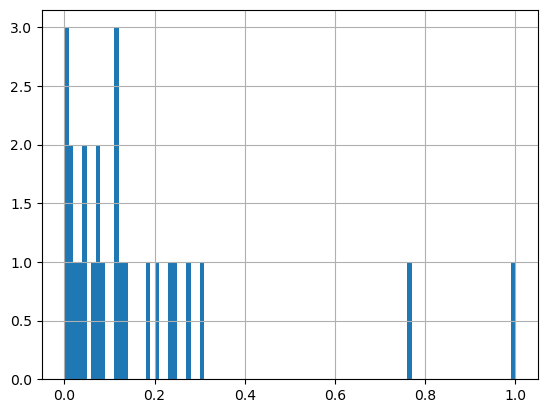

In [16]:
node_stats_df.color.hist(bins=100)

In [497]:
from bqplot import Graph, ColorScale, Figure
import ipywidgets as widgets
import numpy as np

# 转换节点和边数据
node_data = []
for _, row in node_stats_df.iterrows():
    r = np.sqrt(row.total_citations)*0.01
    label_text = node_labels[row.cluster]
    label_loc = 'center'
    if r < 30:
        label_loc = 'outside'
    node_data.append({
        'label': label_text,
        'label_display': label_loc,
        'shape': 'circle',
        'color': row.color,
        'shape_attrs': {'r': r},
    })

link_data = []
for _, row in edge_df.iterrows():    
    link_data.append({
        'source': row.source,
        'target': row.target,
        'value': row.normalized_weight,
    })

# 创建颜色比例尺
node_color_scale = ColorScale(min=node_stats_df.color.min(), 
                             max=node_stats_df.color.max(),
                             colors=['#ffeda0', '#f03b20'])
link_color_scale = ColorScale(min=edge_df.normalized_weight.min(), 
                             mid=edge_df.normalized_weight.mean(),
                             max=edge_df.normalized_weight.max(),
                             colors=['#f7fbff', '#6baed6', '#08306b'])

# 创建图形标记
graph = Graph(
    node_data=node_data,
    link_data=link_data,
    static=True,
    directed=True,
    link_type='arc',
    scales={
        'color': node_color_scale,
        'link_color': link_color_scale
    },
    charge=-2100,
)

# 创建图形并添加图例
figure = Figure(
    marks=[graph],
    layout=widgets.Layout(width='2000px', height='2000px'),
)
figure

Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(height='2000px', width='20…

In [406]:
figure.save_png("citation_map.png", scale=3)

In [538]:
from IPython.display import display, HTML
import numpy as np

# 计算实际显示参数
# 节点大小参数
node_sizes = np.sqrt(node_stats_df['total_citations']) * 0.01
min_size, max_size = node_sizes.min(), node_sizes.max()
size_legend_values = np.linspace(min_size, max_size, 5)
size_labels = [f"{(s/0.01)**2:.0f}" for s in size_legend_values]

# 节点颜色参数
inner_citations_min = node_stats_df['inner_citations'].min()
inner_citations_max = node_stats_df['inner_citations'].max()

# 边颜色参数
edge_min = edge_df['weight'].min()
edge_max = edge_df['weight'].max()

legend_html = f"""
<div style="width: 100%; padding: 15px; background: white; border-radius: 6px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
    <h5 style="margin-top: 0; margin-bottom: 50px; color: #333;">Node Size: Total Citations</h5>
    
    <div style="margin-bottom: -20px;">
        <div style="display: flex; align-items: flex-end; height: 100px; margin-top: 10px;">
            {''.join([f'<div style="display: flex; flex-direction: column; align-items: center; margin: 0 8px;">'
                     f'<div style="width: {s*2}px; height: {s*2}px; border-radius: 50%; '
                     f'background: #ffeda0; border: 1.75px solid #0b0b0b;"></div>'
                     f'<span style="margin-top: 8px; font-size: 12px; color: #333">{label}</span></div>'
                     for s, label in zip(size_legend_values, size_labels)])}
        </div>
    </div>
    
    <h5 style="margin-bottom: 0px; color: #333;">Node Color: Intradisciplinary Citations</h5>
    <div style="height: 10px; width: 100%; background: linear-gradient(to right, #ffeda0, #f03b20); border-radius: 4px;"></div>
    <div style="margin-bottom: -20px; display: flex; justify-content: space-between; font-size: 12px; color: #333">
        <span>{inner_citations_min}</span>
        <span>{inner_citations_min+(inner_citations_max-inner_citations_min)/4:.0f}</span>
        <span>{inner_citations_min+(inner_citations_max-inner_citations_min)/2:.0f}</span>
        <span>{inner_citations_min+(inner_citations_max-inner_citations_min)*3/4:.0f}</span>
        <span>{inner_citations_max}</span>
    </div>

    <h5 style="margin-bottom: 0px; color: #333;">Edge Weight: Interdisciplinary Citations</h5>
    <div style="height: 10px; width: 100%; background: linear-gradient(to right, #f7fbff, #6baed6, #08306b); border-radius: 4px;"></div>
    <div style="margin-bottom: -10px; display: flex; justify-content: space-between;">
        <span style="font-size: 12px; color: #333;">{edge_min}</span>
        <span style="font-size: 12px; color: #333;">{edge_min+(edge_max-edge_min)/4:.0f}</span>
        <span style="font-size: 12px; color: #333;">{edge_min+(edge_max-edge_min)/2:.0f}</span>
        <span style="font-size: 12px; color: #333;">{edge_min+(edge_max-edge_min)*3/4:.0f}</span>
        <span style="font-size: 12px; color: #333;">{edge_max}</span>
    </div>
</div>
"""

# 显示图例
display(HTML(legend_html))

In [680]:
from IPython.display import display
import ipywidgets as widgets

legend_widget = widgets.HTML(value=legend_html)
layout = widgets.VBox([figure, legend_widget], 
                      layout=widgets.Layout(width='1000px', 
                                            height='1400px', 
                                            align_items='center',)
                      )
display(layout)